In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [4]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [5]:
last_date = '2022-12-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World'].query(f'date < "{last_date}"')

syn_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/syn_clade_stats_SARS_CoV_2/'
assert os.path.exists(syn_clade_stats_SARS_CoV_2_folder)

syn_clade_statistics_SARS_CoV_2_World = pd.read_csv(syn_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
syn_clade_statistics_SARS_CoV_2_World = syn_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [6]:
nonsyn_all_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_all_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_all_clade_stats_SARS_CoV_2_folder)

nonsyn_all_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_all_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_all_clade_statistics_SARS_CoV_2_World = nonsyn_all_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')


In [7]:
nonsyn_S_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_S_clade_stats_SARS_CoV_2/'
assert os.path.exists(nonsyn_S_clade_stats_SARS_CoV_2_folder)
nonsyn_S_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_S_clade_statistics_SARS_CoV_2_World = nonsyn_S_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [8]:
nonsyn_RBD_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/RBD_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_RBD_clade_stats_SARS_CoV_2_folder)

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = nonsyn_RBD_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [9]:
nonsyn_S_clade_statistics_driver_mutations = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')
nonsyn_RBD_clade_statistics_driver_mutations = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')

In [10]:
set_S_minus_RBD = set(nonsyn_S_clade_statistics_driver_mutations['Driver_Mutation'] ) - set(nonsyn_RBD_clade_statistics_driver_mutations['Driver_Mutation'] )

index_set_S_minus_RBD = nonsyn_S_clade_statistics_driver_mutations['Driver_Mutation'].isin(set_S_minus_RBD)


In [11]:
nonsyn_S_minus_RBD_clade_stats = nonsyn_S_clade_statistics_driver_mutations[index_set_S_minus_RBD]

In [12]:
nonsyn_S_minus_RBD_clade_stats['Max_Freq'] = nonsyn_S_minus_RBD_clade_stats['Max_Realized_Sublineage_Freq']

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2706/3387389107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonsyn_S_minus_RBD_clade_stats['Max_Freq'] = nonsyn_S_minus_RBD_clade_stats['Max_Realized_Sublineage_Freq']


In [13]:
#create a dataframe with columns, clade, time, max_freq, orig_time
syn_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
syn_clade_stats['Clade'] = syn_clade_statistics_SARS_CoV_2_World['Clade']
syn_clade_stats['Max_Freq'] = syn_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
syn_clade_stats['Orig_Time'] = syn_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
syn_clade_stats = syn_clade_stats.drop_duplicates()

In [14]:
nonsyn_all_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_all_clade_stats['Clade'] = nonsyn_all_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_all_clade_stats['Max_Freq'] = nonsyn_all_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_all_clade_stats['Orig_Time'] = nonsyn_all_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_all_clade_stats = nonsyn_all_clade_stats.drop_duplicates()

nonsyn_S_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_S_clade_stats['Clade'] = nonsyn_S_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_S_clade_stats['Max_Freq'] = nonsyn_S_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_S_clade_stats['Orig_Time'] = nonsyn_S_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_S_clade_stats = nonsyn_S_clade_stats.drop_duplicates()

nonsyn_RBD_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_RBD_clade_stats['Clade'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_RBD_clade_stats['Max_Freq'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_RBD_clade_stats['Orig_Time'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_RBD_clade_stats = nonsyn_RBD_clade_stats.drop_duplicates()



In [15]:
sns.set_style("whitegrid")

x such that ratio>2 for nonsyn all: 2.31e-01
x such that ratio>2 for nonsyn S: 1.02e-01
x such that ratio>2 for nonsyn RBD: 2.01e-02


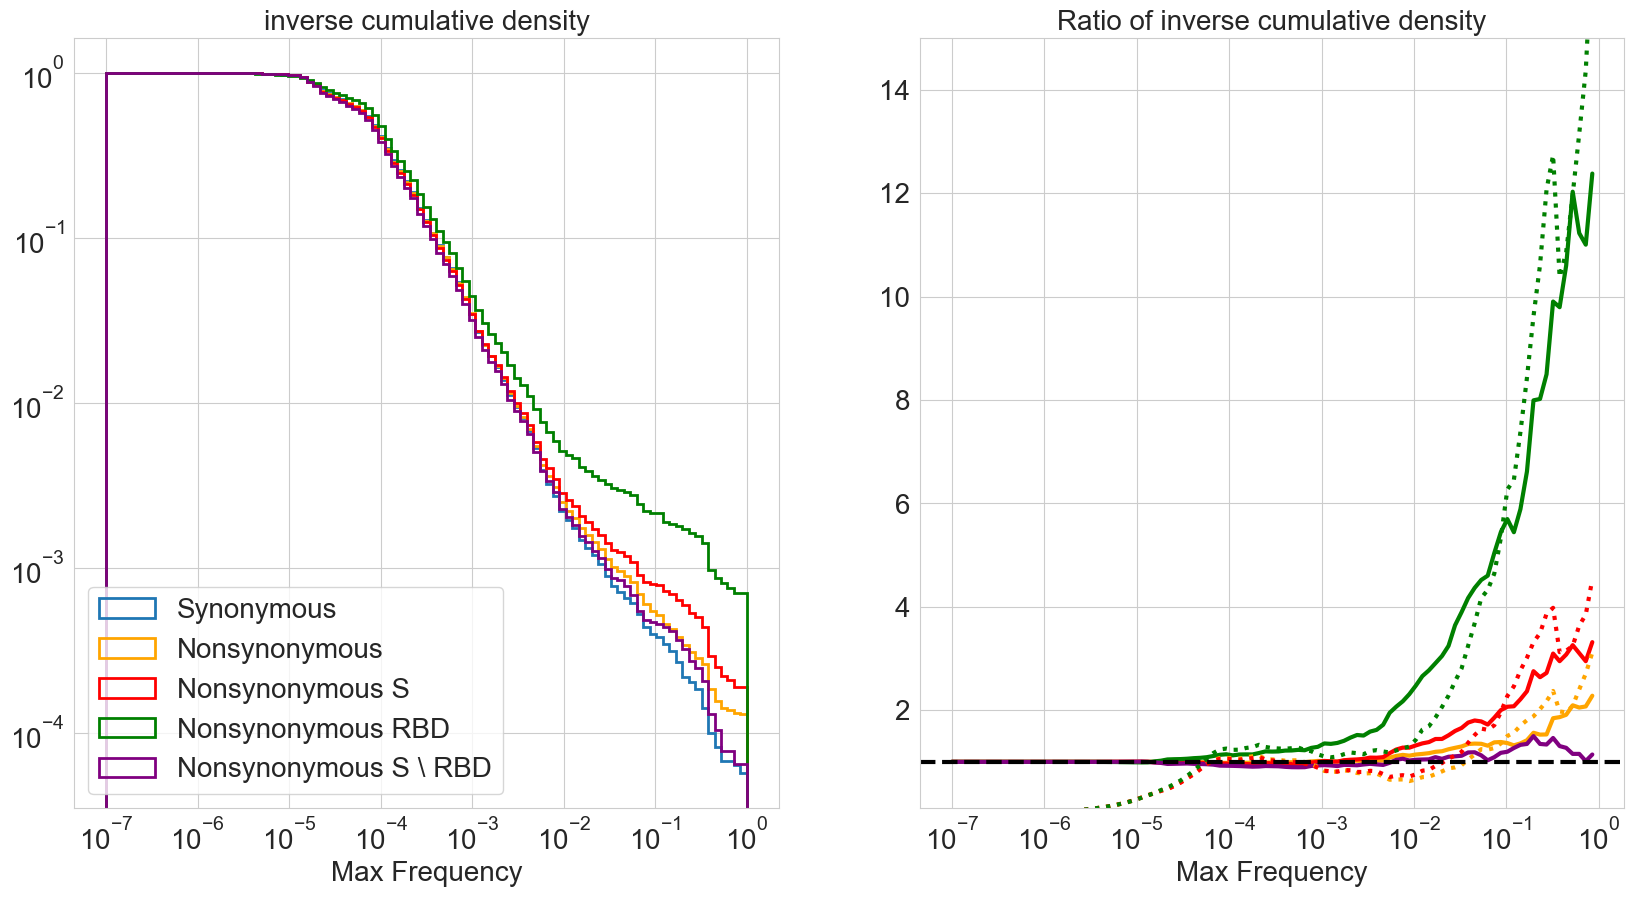

In [19]:
fig, ax = plt.subplots(1,2,figsize = (20,10))

syn_h,syn_b,syn_p = ax[0].hist(syn_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Synonymous',cumulative=-1, histtype = 'step')

nonsyn_all_h,nonsyn_all_b,nonsyn_all_p = ax[0].hist(nonsyn_all_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous',cumulative=-1, histtype = 'step',color='orange')

nonsyn_S_h,nonsyn_S_b,nonsyn_S_p = ax[0].hist(nonsyn_S_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous S',cumulative=-1, histtype = 'step',color='red')

nonsyn_RBD_h,nonsyn_RBD_b,nonsyn_RBD_p = ax[0].hist(nonsyn_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous RBD',cumulative=-1, histtype = 'step',color='green')

nonsyn_S_minus_RBD_h, nonsyn_S_minus_RBD_b, nonsyn_S_minus_RBD_p = ax[0].hist(nonsyn_S_minus_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous S \\ RBD',cumulative=-1, histtype = 'step',color='purple')

#fit syn with b/(1+a x)
fitfunc = lambda x,a,b: b/(1+a*x)
popt, pcov = so.curve_fit(fitfunc, syn_b[50:-1],syn_h[50:])
a,b = popt
one_over_x_fit = fitfunc(syn_b[:-1],a,b)
# ax[0].plot(syn_b[:-1],one_over_x_fit, label = r'$1/x$',color='steelblue',linestyle='--')
ax[0].legend(loc='best',fontsize=20)
ax[1].plot(syn_b[:-1],nonsyn_all_h/syn_h, label = 'Synonymous',color='orange')
ax[1].plot(syn_b[:-1],nonsyn_S_h/syn_h, label = 'Nonsynonymous S',color='red')
ax[1].plot(syn_b[:-1],nonsyn_RBD_h/syn_h, label = 'Nonsynonymous RBD',color='green')
ax[1].plot(syn_b[:-1],nonsyn_S_minus_RBD_h/syn_h, label = 'Nonsynonymous S \\ RBD',color='purple')

ax[1].plot(syn_b[:-1],nonsyn_all_h/one_over_x_fit,color='orange',ls= ':')
ax[1].plot(syn_b[:-1],nonsyn_S_h/one_over_x_fit,color='red',ls= ':')
ax[1].plot(syn_b[:-1],nonsyn_RBD_h/one_over_x_fit,color='green',ls= ':')

print(f'x such that ratio>2 for nonsyn all: {syn_b[np.argwhere(nonsyn_all_h/one_over_x_fit>2)[0][0]]:.2e}')
print(f'x such that ratio>2 for nonsyn S: {syn_b[np.argwhere(nonsyn_S_h/one_over_x_fit>2)[0][0]]:.2e}')
print(f'x such that ratio>2 for nonsyn RBD: {syn_b[np.argwhere(nonsyn_RBD_h/one_over_x_fit>2)[0][0]]:.2e}')

ax[1].set_ylim(.1,15)

ax[1].axhline(1,linestyle='--',color='black')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].set_ylim(10,50)

ax[1].set_xscale('log')

ax[0].set_xlabel('Max Frequency',fontsize=20)
ax[0].set_title('inverse cumulative density',fontsize=20)

ax[1].set_xlabel('Max Frequency',fontsize=20)
ax[1].set_title('Ratio of inverse cumulative density',fontsize=20)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=20)


In [42]:
syn_clade_stats

,Clade,Max_Freq,Orig_Time
0,1,1.000000,2019-11-30
1404,2,0.074760,2020-01-05
1715,3,0.015009,2020-01-15
1800,4,0.000811,2019-12-31
1885,5,0.003500,2019-12-25
...,...,...,...
28146190,280329,0.000030,2023-05-29
28146275,280330,0.000022,2023-05-17
28146360,280331,0.000961,2023-05-27
28146458,280332,0.000410,2023-05-12


In [51]:
syn_clade_stats.count()[0], syn_clade_stats.query('Max_Freq >= 1').count()[0]

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2706/60963270.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  syn_clade_stats.count()[0], syn_clade_stats.query('Max_Freq >= 1').count()[0]
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2706/60963270.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  syn_clade_stats.count()[0], syn_clade_stats.query('Max_Freq >= 1').count()[0]


(280333, 26)

ratio of synonimous mutations: 0.45 compared to 0.40
ratio of nonsynonimous mutations: 0.55 compared to 0.60
genome-wide substitution rate: 24.00 mutations per year per genome


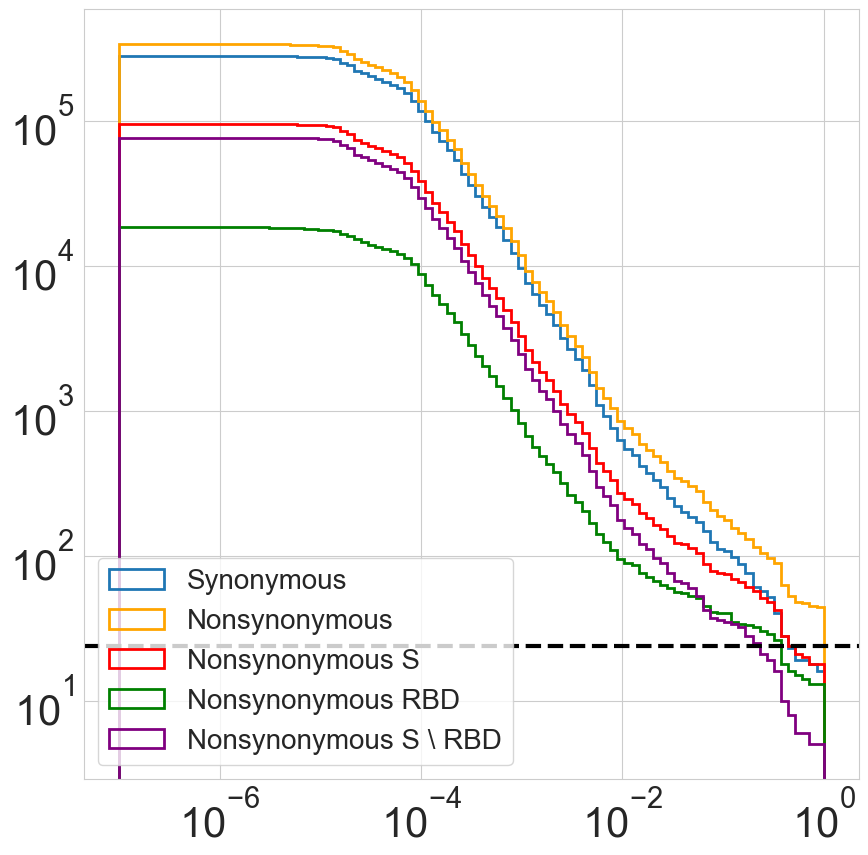

In [49]:
fig,ax =plt.subplots(figsize = (10,10))


syn_h,syn_b,syn_p = ax.hist(syn_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = False, alpha = 1, lw=2, label = 'Synonymous',cumulative=-1, histtype = 'step')

nonsyn_all_h,nonsyn_all_b,nonsyn_all_p = ax.hist(nonsyn_all_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = False, alpha = 1, lw=2, label = 'Nonsynonymous',cumulative=-1, histtype = 'step',color='orange')

nonsyn_S_h,nonsyn_S_b,nonsyn_S_p = ax.hist(nonsyn_S_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = False, alpha = 1, lw=2, label = 'Nonsynonymous S',cumulative=-1, histtype = 'step',color='red')

nonsyn_RBD_h,nonsyn_RBD_b,nonsyn_RBD_p = ax.hist(nonsyn_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = False, alpha = 1, lw=2, label = 'Nonsynonymous RBD',cumulative=-1, histtype = 'step',color='green')

nonsyn_S_minus_RBD_h, nonsyn_S_minus_RBD_b, nonsyn_S_minus_RBD_p = ax.hist(nonsyn_S_minus_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = False, alpha = 1, lw=2, label = 'Nonsynonymous S \\ RBD',cumulative=-1, histtype = 'step',color='purple')

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='best',fontsize=20)

print(f'ratio of synonimous mutations: {syn_clade_stats.shape[0]/(nonsyn_all_clade_stats.shape[0]+syn_clade_stats.shape[0]):.2f} compared to {2/5:.2f}')
print(f'ratio of nonsynonimous mutations: {nonsyn_all_clade_stats.shape[0]/(nonsyn_all_clade_stats.shape[0]+syn_clade_stats.shape[0]):.2f} compared to {3/5:.2f}')


utree = 8e-4
Lsarscov2 = 3e4
psyn = 1/3

U = utree*Lsarscov2*psyn
print(f'genome-wide substitution rate: {3*U:.2f} mutations per year per genome')
ax.axhline(3*U,linestyle='--',color='black')


In [64]:
print(f'genome-wide substitutions over three years: {3*U:.2f} mutations')
print(f'actual substitutions over three years: {syn_clade_stats.query('Max_Freq >= 1').count()[0]} mutations')

print(f'RBD substitutions over three years: {nonsyn_RBD_clade_stats.query("Max_Freq >= 1").count()[0]} mutations')

print(f'supposed L_RBD/L_tot = { nonsyn_RBD_clade_stats.query("Max_Freq >= 1e-4").count()[0]\
         /syn_clade_stats.query("Max_Freq >= 1e-4").count()[0]:.2f}')
print(f'actual ratio: {567/Lsarscov2:.2f}')

genome-wide substitutions over three years: 24.00 mutations
actual substitutions over three years: 26 mutations
RBD substitutions over three years: 16 mutations
supposed L_RBD/L_tot = 0.07
actual ratio: 0.02


/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2706/2002517872.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'actual substitutions over three years: {syn_clade_stats.query('Max_Freq >= 1').count()[0]} mutations')
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2706/2002517872.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'RBD substitutions over three years: {nonsyn_RBD_clade_stats.query("Max_Freq >= 1").count()[0]} mutations')
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2706/2002517872.py:6: FutureWarning: Series.__getitem__ treating keys as positions is

In [60]:
520-331

189